In [128]:
from cProfile import label

from fontTools.misc.bezierTools import calcQuadraticArcLength

'''
Assignment 2
Student: NAME SURNAME
'''

# *** Packages ***
#!pip install torch==2.4 # Run just once
import torch.nn as nn
import torch.nn.functional as F
from math import floor
import torch

if __name__ == "__main__":
    # Write your code here
    print("Hello World!")

    '''
    DON'T MODIFY THE SEED!
    '''
    # Set the seed for reproducibility
    manual_seed = 42
    torch.manual_seed(manual_seed)

Hello World!


In [129]:
manual_seed = 42
torch.manual_seed(manual_seed)
# first dimension stay equal, second value change
torch.randint(1, 10 , (1,1))

tensor([[7]])

In [130]:

import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


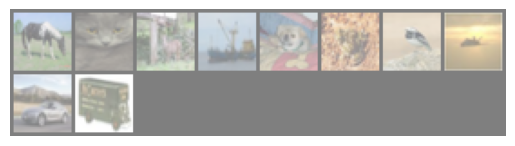

Classes: ['horse', 'cat', 'deer', 'ship', 'dog', 'frog', 'bird', 'plane', 'car', 'truck']


In [131]:
import torchvision

batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img, title=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    #plt.title("Class: " + title)
    plt.show()

dist_train_classes = dict.fromkeys(classes, 0)
dist_test_classes = dict.fromkeys(classes, 0)
img_list = []
class_list = []

for j in range(len(trainloader)):
    dataiter = iter(trainloader)
    for i in range(batch_size):
        #print(labels[i].item())
        #print(classes[labels[i].item()])
        images, labels = next(dataiter)
        current_class = classes[labels[i].item()]
        
        if dist_train_classes[current_class] == 0:
            img_list.append(images[i])
            class_list.append(current_class)
            #imshow(images[i], current_class)
        
        dist_train_classes[current_class] = dist_train_classes[current_class] + 1
        
imshow(torchvision.utils.make_grid(img_list))
print(f"Classes: {class_list}")

        
for j in range(len(testloader)):
    dataiter = iter(testloader)
    for i in range(batch_size):
        #print(labels[i].item())
        #print(classes[labels[i].item()])
        images, labels = next(dataiter)
        current_class = classes[labels[i].item()]
        
        dist_test_classes[current_class] = dist_test_classes[current_class] + 1

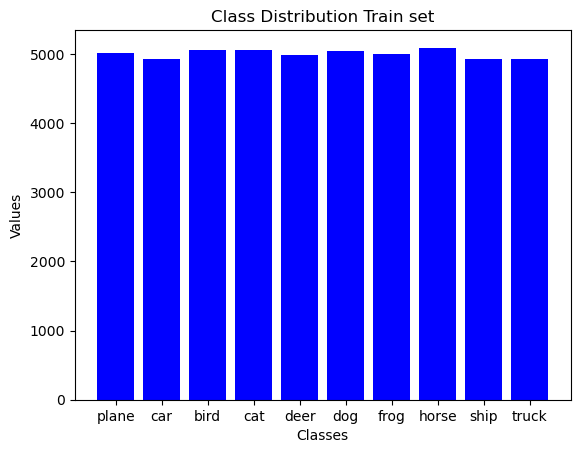

In [132]:
# Extract keys and values for plotting
keys = list(dist_train_classes.keys())
values = list(dist_train_classes.values())

# Create the histogram
plt.bar(keys, values, color='blue')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Values')
plt.title('Class Distribution Train set')

# Show the plot
plt.show()

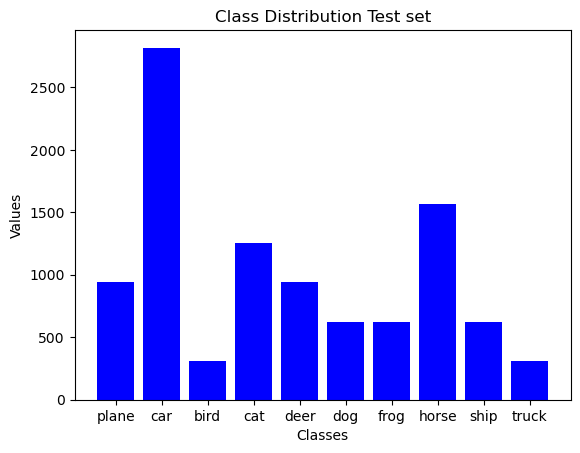

In [133]:
# Extract keys and values for plotting
keys = list(dist_test_classes.keys())
values = list(dist_test_classes.values())

# Create the histogram
plt.bar(keys, values, color='blue')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Values')
plt.title('Class Distribution Test set')

# Show the plot
plt.show()

In [134]:
# Q3 - cast images
# we want a 3x32x32 => 3 channels, 32 width, 32 height
dataiter = iter(testloader)
images, labels = next(dataiter)

# [batch size, channels, height, width]
print(images.shape)
print(images[0].shape)

torch.Size([32, 3, 32, 32])
torch.Size([3, 32, 32])


In [135]:
# Q4 - Normalize data
#for j in range(len(trainloader)):
#    dataiter = iter(trainloader)
#    for i in range(batch_size):
#        images, labels = next(dataiter)
transformer = transforms.Compose([transforms.Normalize(mean=0, std=1)])
images = transformer(images)

In [136]:
# Q5 - Make validation
validset, testset = torch.utils.data.random_split(testset, [0.5, 0.5])
testloader = DataLoader(testset, batch_size=len(testset))
validloader = DataLoader(validset, batch_size=len(validset))
print("We have", len(validset), "items for validation and", len(testset), "items for test")

We have 5000 items for validation and 5000 items for test


In [137]:
# Q6 - CNN
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out
    
# You can start by modifyng what we have done in class, or define your model from scratch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        # You can double this block! 
        self.fc1 = nn.Linear(32 * h_out * w_out, 10) # What does 32 represent?
        # You can add one fully connected layer. What do you have to change?
        self.dimensions_final = (32, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        return x

In [156]:
#Q7 - Training
import torch.optim as optim

model = CNN()
learning_rate = 0.031
n_epochs = 4
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [157]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

train_loss_list = []
validation_loss_list = []
for epoch in range(n_epochs):
    loss_train = 0
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)
    

Working on mps
Epoch 1: Train loss: 1.60783590373517, Validation loss 1.3513158559799194
Epoch 2: Train loss: 1.250759290451433, Validation loss 1.1996326446533203
Epoch 3: Train loss: 1.1225523939517088, Validation loss 1.241890788078308
Epoch 4: Train loss: 1.0262213167439496, Validation loss 1.0769046545028687


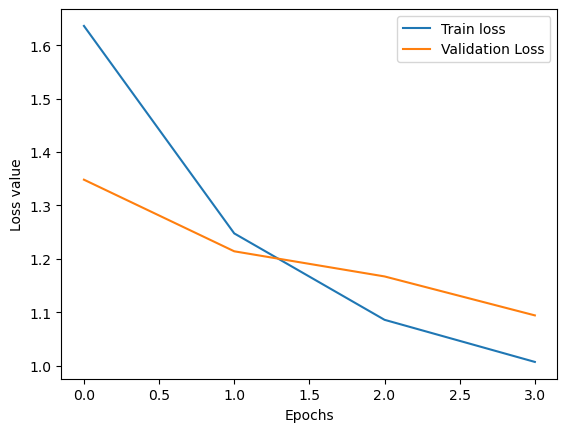

In [155]:
# Q8 - train and val loss
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

In [147]:
# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 63.82 %
